# Assginment 2 : Image Mosaicing 

Submitted by :<br>
Archit Kumar<br>
2018201051

##  Question  1 : Using Feature Detector  and descriptor  

<b>ORB Detector and Descriptor : An efficient alternative to SIFT or SURF</b> <br>
ORB is basically a fusion of FAST keypoint detector and BRIEF descriptor with many modifications to enhance the performance. First it use FAST to find keypoints, then apply Harris corner measure to find top N points among them. It also use pyramid to produce multiscale-features.


#### Result of ORB  :  

<img src = "mark1.png">
<img src= "mark2.png">

## Question 2 : Robust (RANSAC) estimation of  Homography matrix between two images

A 2D homography is an invertible mapping h from P2 to itself such that three points x1,x2,x3 lie
on the same line if and only if h(x1),h(x2),h(x3) do. <br><br>
A mapping h: P2 - > P2 is a homography if and only if there exist a non‐singular 3x3 matrix H
such that for any point in P2 represented by a vector x it is true that h(x)= Hx 



### RANSAC ALGO 

1: Select randomly the minimum number of points required to determine the model
parameters.<br>
2: Solve for the parameters of the model.<br>
3: Determine how many points from the set of all points fit with a predefined tolerance .<br>
4: If the fraction of the number of inliers over the total number points in the set exceeds a predefined threshold τ , re-estimate the model parameters using all the identified inliers and terminate.<br>
5: Otherwise, repeat steps 1 through 4 (maximum of N times)

In [ ]:
def calculateHomography(pt1,pt2):
    A = []
    pt1 = pt1[:4]
    pt2 = pt2[:4]
    for i in range(len(pt1)):
        x = pt1[i][0]
        y = pt1[i][1]
        a = pt2[i][0]
        b = pt2[i][1]
        A.append([x,y,1,0,0,0,-a*x,-a*y,-a])
        A.append([0,0,0,x,y,1,-b*x, -b*y , -b])
    A = np.asarray(A)
    U, s, V = np.linalg.svd(A,full_matrices=True)
    H = V[-1,:]/V[-1,-1]
    return H.reshape(3,3)
        

In [58]:
def geometricDistance(p1,p2, h):

    p1 = np.transpose(np.matrix([ p1[0] , p1[1] , 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([ p2[0] , p2[1] , 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)

In [79]:
import random
def ransac(pt1 , pt2 , thresh):
    maxInliers = []
    finalH = None
    for i in range(1000):        
        p1 = []
        p2 = []

        r_num = random.randrange(0, len(pt1))
        p1.append(pt1[r_num])
        p2.append(pt2[r_num])
        cm = [[941,12724,481 , 197,10],[6805,20,29,0,0], [1368,578,1052,0,0], [0,8,0,0,0],[0,34,751,0,0]]

        r_num = random.randrange(0, len(pt1))
        p1.append(pt1[r_num])
        p2.append(pt2[r_num])
        
        r_num = random.randrange(0, len(pt1))
        p1.append(pt1[r_num])
        p2.append(pt2[r_num])
        
        r_num = random.randrange(0, len(pt1))
        p1.append(pt1[r_num])
        p2.append(pt2[r_num])
        

        #call the homography function on those points
        h = calculateHomography(p1,p2)
        inliers = []

        for i in range(len(pt1)):
            d = geometricDistance(pt1[i],pt2[i], h)
            if d < 5:
                inliers.append([pt1[i],pt2[i]])

        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = h
#         print "Corr size: ", len(pt1), " NumInliers: ", len(inliers), "Max inliers: ", len(maxInliers)

        if len(maxInliers) > (len(pt1)*thresh):
            break
    return finalH, maxInliers


### Question 3 : 
### Transform one of the images to the others reference frame using the homography matrix. 

Perspective Transformated image is basically a transformed version of an image into the perspective of second image.<br>
<b><i>code for Result generated  in this part is described in next part.</i></b>
<br>
<img src = "imgs/img2_3.png" style = "width : 500px">
first image
<img src = "imgs/img2_3.png" style = "width : 500px">
second image 
<img src = "perspective.png" >
transformed image

## Question 4 : 
### Image sticher

Following steps are used to stich two images (img1 ,img2 ) together<br>
1. use feature descriptor to detect key points and corresponding descriptor in both images<br>
2. use a matcher(ex  : brute force matcher ) to match simillar points in images<br>
3. draw the matched points on  a combined images<br>
4. calculate homography matrix using ransac algo<br>
5. Create perspective transformation of one image<br>
6. Attach second image in transformed image

In [85]:
def sticher(img1 ,  img2 , direction = 'h'):
    img2 = img2[:img1.shape[0] , :]
    orb = cv2.ORB_create()

    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
    matches = bf.match(des1,des2)
    matches = sorted(matches, key = lambda x:x.distance)

    list_kp1 = [kp1[mat.queryIdx].pt for mat in matches] 
    list_kp2 = [kp2[mat.trainIdx].pt for mat in matches]

    H, inliers = ransac(list_kp1 , list_kp2 , 0.8)

    img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:50] ,None, flags=2)

    result = cv2.warpPerspective(img1, H,(img1.shape[1] + img2.shape[1], img1.shape[0]))
    result_per = np.copy(result)
    result[0:img2.shape[0],0:img2.shape[1]] = img2
    return H , img3 , result_per , result

    

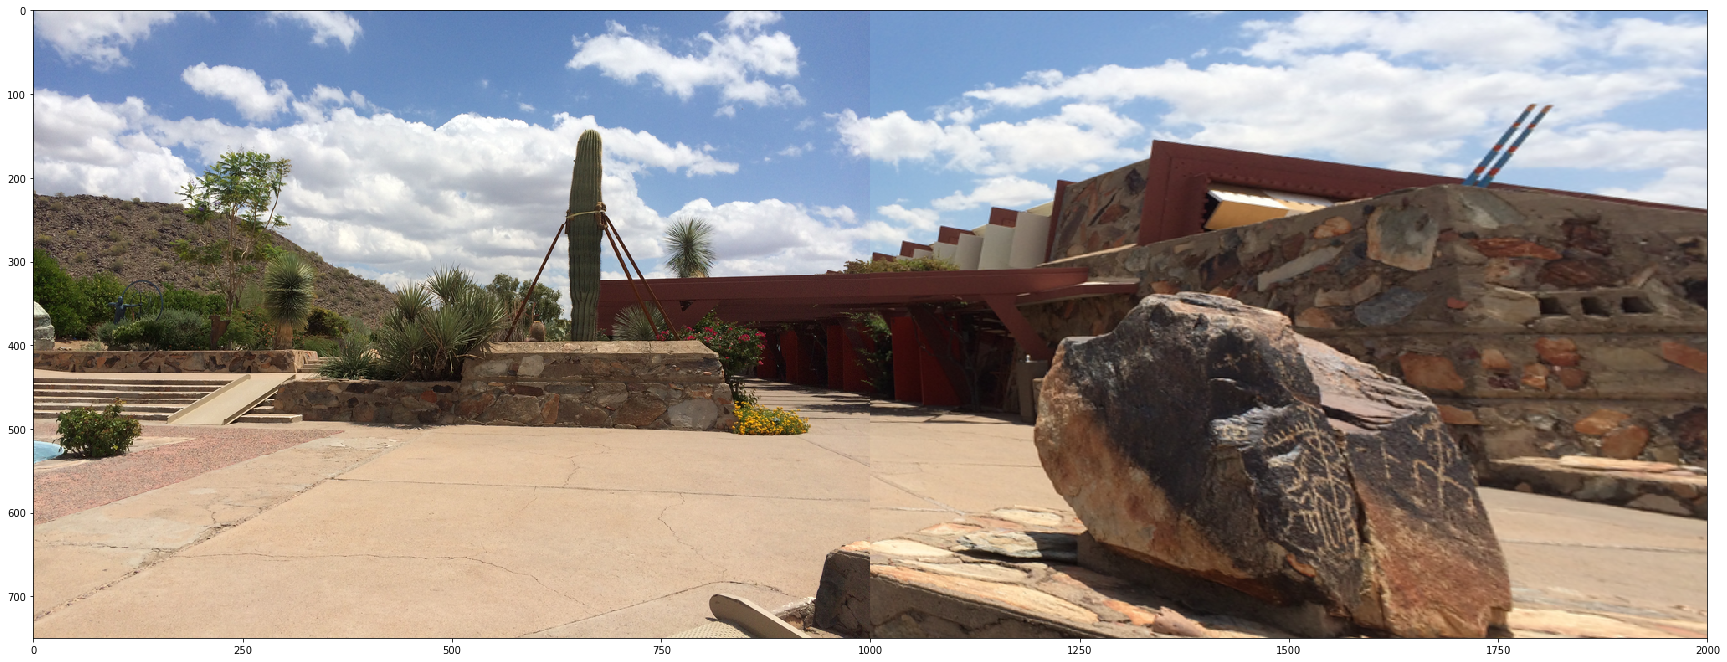

In [87]:
img2 = cv2.imread('imgs/img3_1.png') 
img1 = cv2.imread('imgs/img3_2.png') 
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
H ,a , rp , img = sticher(img1 , img2)
plt.figure(figsize=(30,20))
plt.imshow(img)
plt.show()

### Image stiching on self captured images

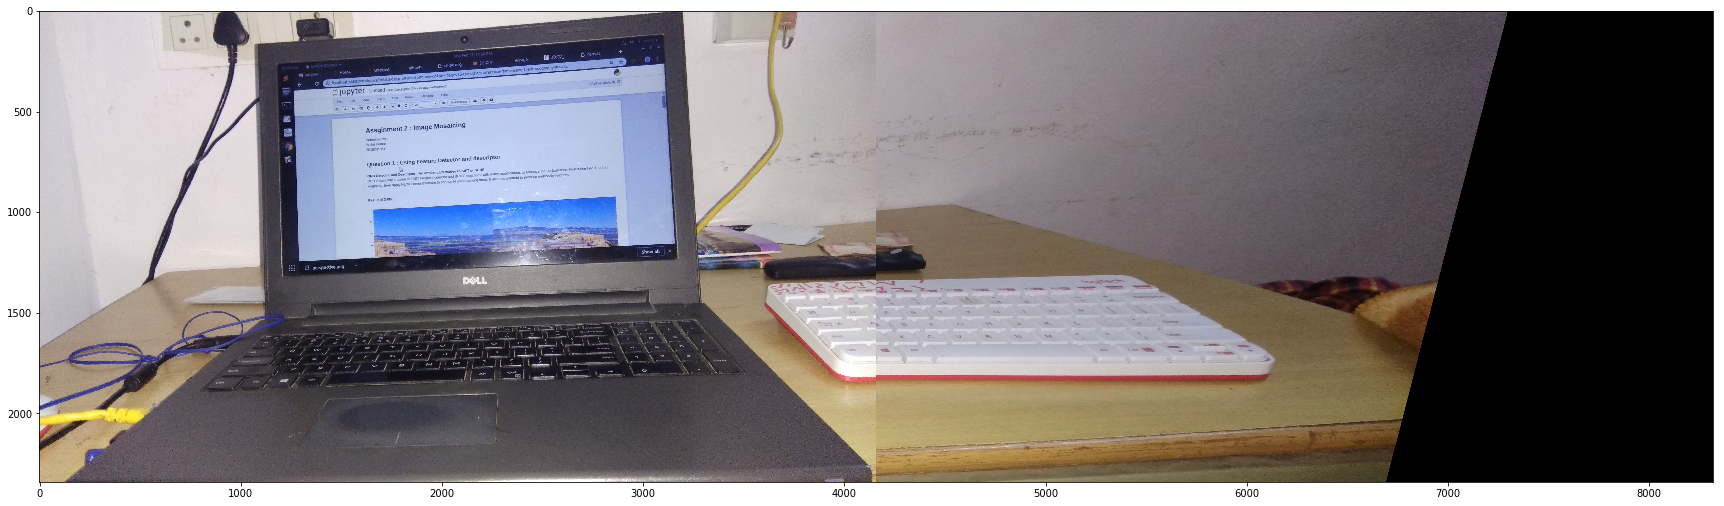

In [89]:
img2 = cv2.imread('imgs/cam1.jpg') 
img1 = cv2.imread('imgs/cam2.jpg') 
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
H ,a , rp , img = sticher(img1 , img2)
plt.figure(figsize=(30,20))
plt.imshow(img)
plt.show()

## Question 5 : Producing  a Panorma
Panorma image is simply stiching of more than two images.<br>
Following examples shows the two example of panorma stiching.

#### Example  1 :  

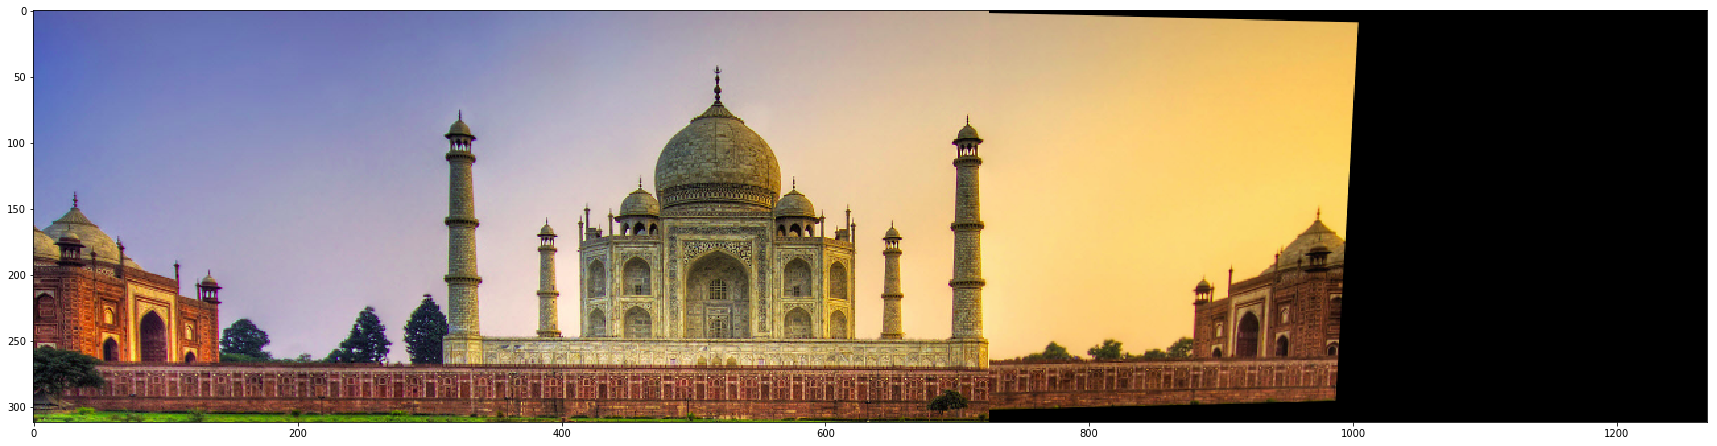

In [88]:
img2 = cv2.imread('imgs/img2_1.png') 
img1 = cv2.imread('imgs/img2_2.png') 
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
H ,a , rp , img5  = sticher(img1 , img2)
img3 = cv2.imread('imgs/img2_3.png') 
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
H , a, rp ,img = sticher(img3, img2)
# a, img = sticher(img5, img3)
plt.figure(figsize=(30,20))
plt.imshow(img)
plt.show()

#### Example 2 :  

In [64]:
img2 = cv2.imread('imgs/img2_5.png') 
img1 = cv2.imread('imgs/img2_6.png') 
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
H ,a , img5  = sticher(img1 , img2)
img3 = cv2.imread('imgs/img2_4.png') 
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
H , a, img = sticher(img5, img3)


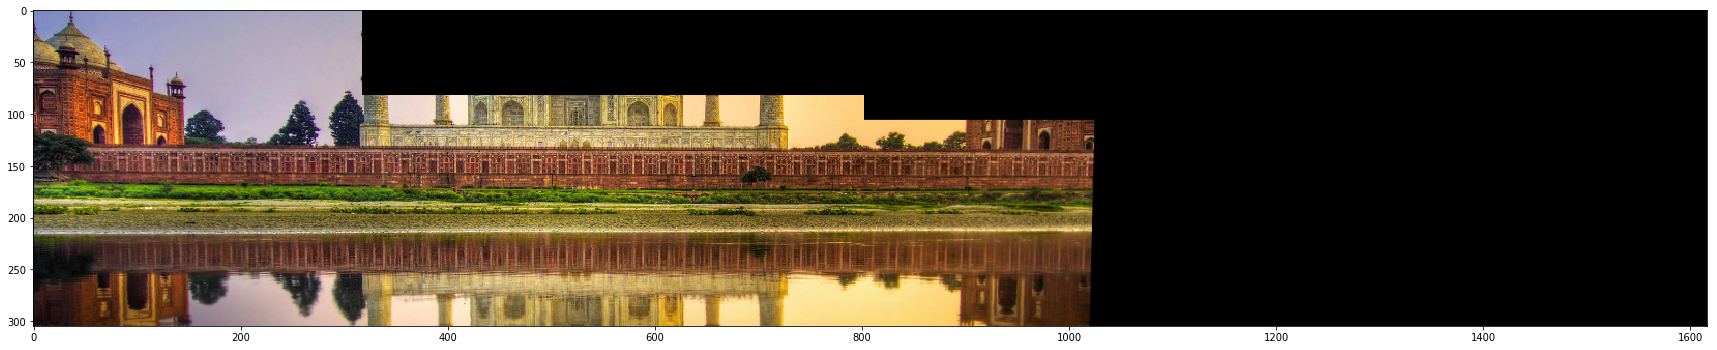

In [69]:
plt.figure(figsize=(30,20))
plt.imshow(img)
plt.show()